In [1]:
import jupyter_addons as ja
ja.set_css()

# ESTIMATING ENERGY CONSUMPTION OF A HEAT PUMP USING THE BIN METHOD
---

An air-to-water heat pump is used to heat a building during the heating season. The heat pump is also used to produce domestic hot water. Using the bin method, the heat pump's energy consumption can be estimated.

In [2]:
from hvac import Quantity
from hvac.fluids import Fluid
from hvac.charts import LineChart
from hvac.energy_estimation import (
    TimeSegment,
    BinTableCreator,
    EnergyEstimator,
    HeatPump,
    HeatingLoad
)

In [3]:
Q_ = Quantity
Water = Fluid('Water')

## Creating a Temperature Bin Table

A temperature bin table can be created from TMY data. TMY data of a given geographic location can be retrieved e.g. from [here](https://re.jrc.ec.europa.eu/pvg_tools/en/). The TMY data has been downloaded into a csv-file that resides in the same folder as this notebook. Class `BinTableCreator` reads the TMY data from the csv-file to create the temperature bin tables for each month of the year. In this example we'll create a temperature bin table for the month December. We will divide each day of the month in four time segments: night, morning, afternoon, and evening.

In [4]:
bin_table_creator = BinTableCreator(
    file_path='tmy_ghent.csv',
    date_time_column_name='time',
    temperature_column_name='T2m',
    bin_limits=(Q_(-10, 'degC'), Q_(35, 'degC')),
    time_segments=[
        TimeSegment('night', (0, 7)),
        TimeSegment('morning', (7, 12)),
        TimeSegment('afternoon', (12, 18)),
        TimeSegment('evening', (18, 24))
    ]
)

Parameter `date_time_column_name` tells in which column of the csv-file the date-times are listed. Parameter `temperature_column_name` tells in which column of the csv-file the outdoor air temperatures are listed. Parameter `bin_limits` contains the lower and the upper limit of the temperature range that will be binned. The specified bin limits should correspond with the lower and the upper limit of the heat pump performance table (to avoid interpolating the heat pump performance characteristics beyond the available temperature range in the heat pump performance table). 

After instantiating the `BinTableCreator` class, we can retrieve the bin table for December:

In [5]:
tbl_Dec = bin_table_creator.get_bin_table(12)
ja.display_table(tbl_Dec)

,night,morning,afternoon,evening
T2m,,,,
"(-10, -8]",0,0,0,0
"(-8, -6]",0,0,0,0
"(-6, -4]",5,1,0,1
"(-4, -2]",16,10,1,9
"(-2, 0]",14,14,19,23
"(0, 2]",38,16,9,23
"(2, 4]",52,30,37,52
"(4, 6]",51,40,29,46
"(6, 8]",33,30,59,25


The bin table tells us how many hours of the month the outdoor air temperature is in a certain temperature bin of a certain time segment. E.g. during nighttime (between 0h and 7h, 7h not included) the outdoor air temperature in December lies in the temperature bin (-4, -2] °C during 16 hours of the month. 

## Define the Heating Loads

A different heating load can be associated with each time segment. It's assumed that domestic hot water is produced by the heat pump during nighttime and stored in a DHW-tank. Four people live in the house. It is estimated that each person consumes 50 liters of hot water a day. We'll write a quick function to calculate the average heating power that's needed to heat cold water to a comfortable hot water temperature during nighttime.  

In [6]:
def average_dhw_heating_power():
    volume = Q_(200, 'liter')
    cold_water = Water(T=Q_(10, 'degC'), P=Q_(101_325, 'Pa'))
    hot_water = Water(T=Q_(50, 'degC'), P=Q_(101_325, 'Pa'))
    rho_avg = (cold_water.rho + hot_water.rho) / 2
    cp_avg = (cold_water.cp + hot_water.cp) / 2
    dQ = rho_avg * cp_avg * volume * (hot_water.T - cold_water.T)
    dt_night = Q_(7, 'hr')
    Q_dot_avg = dQ.to('kJ') / dt_night.to('s')
    return Q_dot_avg    

In [7]:
Q_dot_dhw = average_dhw_heating_power()
print(Q_dot_dhw.to('kW'))

1.3214512436938466 kilowatt


### Heating Load 'Night'

To create a `HeatingLoad` object, we need to define:
- the indoor temperature setpoint
- the minimum outdoor temperature used in the heating load calculation of the building
- the transmission heat loss coefficient of the building, which can be derived from the heating load calculation
- the ventilation and infiltration air volume flow rate,
- the internal heat gain in the building,
- the efficiency of the heating system, i.e. the ratio of heat emitted in the building to the heat produced by the heater in the heating system,
- optionally, the heating load due to domestic hot water production.

With these inputs the *heating load line* of the building can be derived, i.e. the heating load as a function of the outdoor temperature.

In [8]:
load_night = HeatingLoad(
    T_int=Q_(20, 'degC'),
    T_ext_min=Q_(-8, 'degC'),
    H_trm=Q_(4 / 28, 'kW / K'),
    V_dot_ven=Q_(50, 'm**3 / hr'),
    Q_dot_ihg=Q_(0, 'W'),
    eta_sys=Q_(90, 'pct'),
    Q_dot_dhw=Q_dot_dhw  # domestic hot water heating
)

### Heating Load 'Morning'

In [9]:
load_morning = HeatingLoad(
    T_int=Q_(22, 'degC'),
    T_ext_min=Q_(-8, 'degC'),
    H_trm=Q_(4 / 28, 'kW / K'),
    V_dot_ven=Q_(100, 'm**3 / hr'),
    Q_dot_ihg=Q_(500, 'W'),
    eta_sys=Q_(90, 'pct'),
)

### Heating Load 'Afternoon'

In [10]:
load_afternoon = HeatingLoad(
    T_int=Q_(20, 'degC'),
    T_ext_min=Q_(-8, 'degC'),
    H_trm=Q_(4 / 28, 'kW / K'),
    V_dot_ven=Q_(100, 'm**3 / hr'),
    Q_dot_ihg=Q_(500, 'W'),
    eta_sys=Q_(90, 'pct'),
)

### Heating Load 'Evening'

In [11]:
load_evening = HeatingLoad(
    T_int=Q_(22, 'degC'),
    T_ext_min=Q_(-8, 'degC'),
    H_trm=Q_(4 / 28, 'kW / K'),
    V_dot_ven=Q_(100, 'm**3 / hr'),
    Q_dot_ihg=Q_(700, 'W'),
    eta_sys=Q_(90, 'pct'),
)

## Define the Heat Pump Operating States

In this example an air-to-water heat pump *Atlantic, Alféa Extensa A.I 5* is used. The technical manual contains the performance table that tabulates the heat pump's performance as a function of outdoor air temperature at different water leaving temperatures (25 °C, 30 °C, ..., 55 °C); see document *hp_performance_table.pdf* in this folder. It's assumed that when the heat pump operates for space heating only, the water leaving temperature is at 35 °C. When domestic hot water is produced, the water leaving temperature is increased to 55 °C. So, we need the heat pump performance as a function of outdoor air temperature for a water leaving temperature of 35 °C (W35) and for a water leaving temperature of 55 °C (W55). For both water leaving temperatures, we prepare as csv-file with three columns: outdoor air temperature, heating capacity, and input power. Next, we can define a `HeatPump` object for each time segment.

### Heat pump 'Night'

In [12]:
hp_night = HeatPump("hp_atlantic_alfea_extensa_AI5_W55.csv")

In the time segment 'Night' domestic hot water is being produced, so we need the heat pump performance for a water leaving temperature of 55 °C (W55).

Now, we need to attach the heating load 'Night' to the heat pump 'Night':

In [13]:
hp_night.load = load_night

We can plot the heating load line and the heat pump capacity line as a function of outdoor air temperature:

In [14]:
def plot(load, hp):
    load_T_ext_rng, load_Q_dot_rng = load.get_characteristic()
    hp_T_ext_rng, hp_Q_dot_rng = hp.get_heating_capacity_characteristic()
    
    chart = LineChart()
    chart.add_xy_data(
        label='heating load line',
        x1_values=load_T_ext_rng.to('degC'),
        y1_values=load_Q_dot_rng.to('kW')
    )
    chart.add_xy_data(
        label='heat pump capacity',
        x1_values=hp_T_ext_rng.to('degC'),
        y1_values=hp_Q_dot_rng.to('kW')
    )
    chart.add_legend()
    chart.x1.add_title('outdoor temperature, °C')
    chart.y1.add_title('heating load/heat pump capacity, kW')
    chart.show()

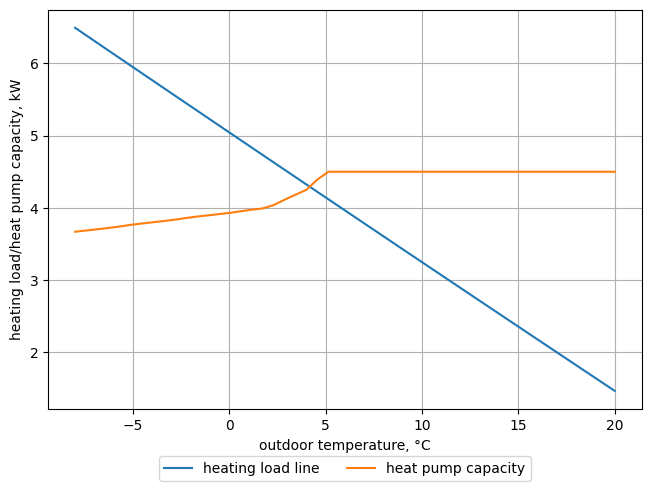

In [15]:
plot(load_night, hp_night)

The heating load line and the heat pump capacity curve intersect at the heat pump's balance point. In this point the heating capacity of the heat pump matches the heating load. When the outdoor temperature is higher than the balance point temperature, the heat pump has more heating capacity than there is heating load present, and we say that the heat pump is running at part-load. When the outdoor temperature is below the balance point temperature, the heating load is greater than the heat pump's heating capacity. Under these circumstances an auxiliary heater must deliver the additional heat to match the heating load.

In [16]:
T_bal, Q_dot_bal = hp_night.balance_point
print(
    f"balance point temperature = {T_bal.to('degC'):~P.1f}",
    f"balance point heating capacity = {Q_dot_bal.to('kW'):~P.3f}",
    sep='\n'
)

balance point temperature = 4.2 °C
balance point heating capacity = 4.293 kW


### Heat Pump 'Morning'

Except in time segment 'Night', the water leaving temperature at the heat pump is set to 35 °C for space heating only (underfloor heating). So, we now use the csv-file with the heat pump performance characteristics for a leaving water temperature of 35 °C.

In [17]:
hp_morning = HeatPump(file_path="hp_atlantic_alfea_extensa_AI5_W35.csv")
hp_morning.load = load_morning

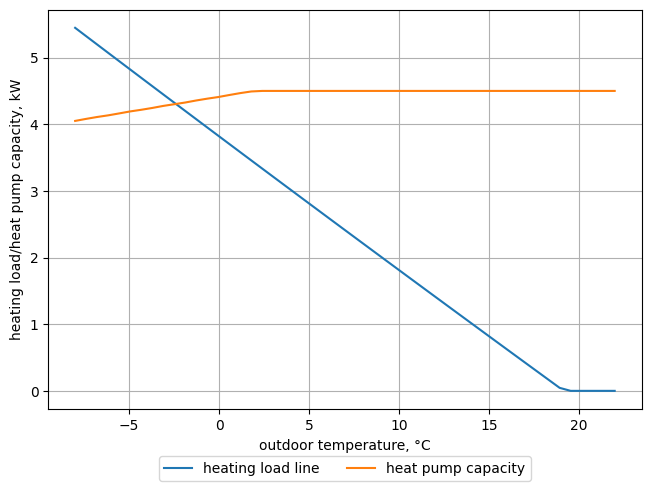

In [18]:
plot(load_morning, hp_morning)

In [19]:
T_bal, Q_dot_bal = hp_morning.balance_point
print(
    f"balance point temperature = {T_bal.to('degC'):~P.1f}",
    f"balance point heating capacity = {Q_dot_bal.to('kW'):~P.3f}",
    sep='\n'
)

balance point temperature = -2.4 °C
balance point heating capacity = 4.304 kW


### Heat Pump 'Afternoon'

In [20]:
hp_afternoon = HeatPump(file_path="hp_atlantic_alfea_extensa_AI5_W35.csv")
hp_afternoon.load = load_afternoon

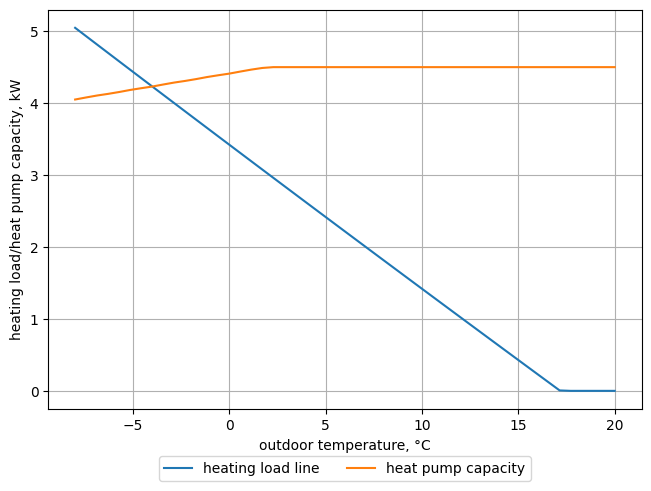

In [21]:
plot(load_afternoon, hp_afternoon)

In [22]:
T_bal, Q_dot_bal = hp_afternoon.balance_point
print(
    f"balance point temperature = {T_bal.to('degC'):~P.1f}",
    f"balance point heating capacity = {Q_dot_bal.to('kW'):~P.3f}",
    sep='\n'
)

balance point temperature = -4.0 °C
balance point heating capacity = 4.230 kW


### Heat Pump 'Evening'

In [23]:
hp_evening = HeatPump(file_path="hp_atlantic_alfea_extensa_AI5_W35.csv")
hp_evening.load = load_evening

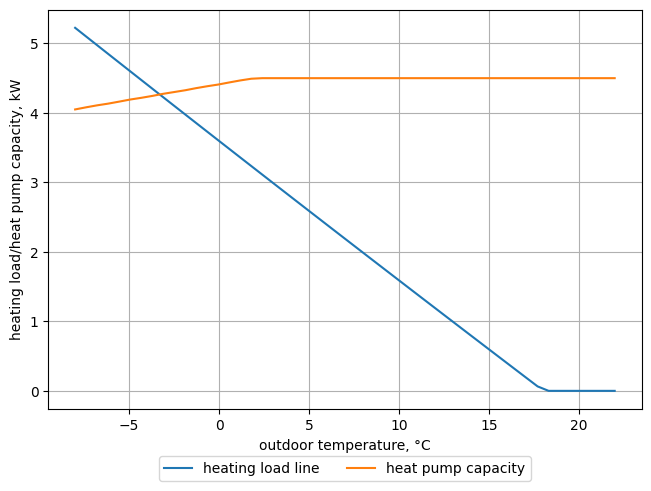

In [24]:
plot(load_evening, hp_evening)

In [25]:
T_bal, Q_dot_bal = hp_evening.balance_point
print(
    f"balance point temperature = {T_bal.to('degC'):~P.1f}",
    f"balance point heating capacity = {Q_dot_bal.to('kW'):~P.3f}",
    sep='\n'
)

balance point temperature = -3.3 °C
balance point heating capacity = 4.265 kW


## Estimating Monthly Energy Consumption of the Heat Pump System and Monthly Heating Energy Need of the Building

### Energy Consumption of the Heat Pump System

To get an estimation of the electrical energy that the heat pump system will consume during a typical month December, we use the class `EnergyEstimator`. When instantiating this class, we pass the bin table and a list with the operating states of the heat pump system in each time segment of the bin table, ordered in the same way as we entered the time segments when creating the bin table.

In [26]:
input_estimator_Dec = EnergyEstimator(
    bin_table=tbl_Dec,
    heat_pumps=[hp_night, hp_morning, hp_afternoon, hp_evening]
)

When we call the method `estimate(...)` on this `EnergyEstimator` object, a Pandas `DataFrame` will be returned with the calculated energy consumption in each time segment and temperature bin. The default units for temperature and energy in the dataframe are degrees Celsius and kilowatt-hour, but these units can be changed through the optional parameters `T_unit` and `E_unit` when calling the method `estimate`.

In [27]:
consumption_Dec = input_estimator_Dec.estimate()
ja.display_table(consumption_Dec)

From the table, it follows that in a typical month December the heat pump system will consume around 951 kWh of electricity. Around 838 kWh is consumed by the heat pump. The auxiliary heater consumes around 113 kWh to assist the heat pump at moments when outdoor air temperature is lower than the heat pump's balance point temperature. 

### Heating Energy Needs of the Building

The same `EnergyEstimator` class can also be used to estimate the monthly heating energy needs of the building. For this, we need to pass the `HeatingLoad` objects to the estimator (instead of the `HeatPump` objects):

In [28]:
output_estimator_Dec = EnergyEstimator(
    bin_table=tbl_Dec,
    loads=[load_night, load_morning, load_afternoon, load_evening]
)

In [29]:
needs_Dec = output_estimator_Dec.estimate()
ja.display_table(needs_Dec)

,night,morning,afternoon,evening,TOTAL
T2m,,,,,
"(-10, -8]",0.000000,0.000000,0.000000,0.000000,0.000000
"(-8, -6]",0.000000,0.000000,0.000000,0.000000,0.000000
"(-6, -4]",29.737962,4.834047,0.000000,4.611825,39.183834
"(-4, -2]",89.372239,44.272465,4.028622,37.845218,175.518544
"(-2, 0]",73.144280,56.304687,68.850977,87.389446,285.689389
"(0, 2]",184.834171,57.881083,28.981146,78.092945,349.789345
"(2, 4]",234.215682,96.438917,104.257448,155.605234,590.517282
"(4, 6]",211.387312,112.516959,70.082336,119.172281,513.158888
"(6, 8]",124.942891,72.372619,118.984737,54.754960,371.055207


It follows that the heat pump system must supply around 2445 kWh of heat energy to the building during a typical month December and will therefore consume around 951 kWh of electricity. This corresponds with a monthly average COP of:

In [30]:
energy_out = needs_Dec.iloc[-1, -1]
energy_in = consumption_Dec.iloc[-1, -1]
COP_avg_Dec = energy_out / energy_in
print(f"monthly average COP in December = {COP_avg_Dec:.2f}")

monthly average COP in December = 2.57


### Distribution of Heating Energy Needs

By plotting the heating energy needs against outdoor temperature in a bar chart, we can find out at which outdoor temperatures the energy needs will be highest. This could be used as a criterion for selecting a suitable heat pump for the building. 

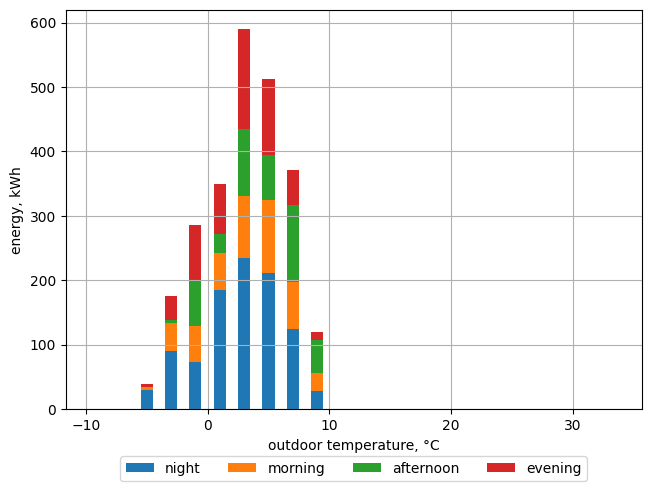

In [31]:
bar_chart = output_estimator_Dec.draw_bar_chart()
bar_chart.show()

## Estimating the Seasonal Energy Consumption of the Heat Pump System

If we can assume that the daily profile of heating loads in the building does not change in the course of the heating season, we can easily extend the above to get an estimation of the energy consumption during a typical heating season. The heating season includes the months October, November, December, January, February, March, and April.

In [32]:
heating_season = [10, 11, 12, 1, 2, 3, 4]
bin_tables = [bin_table_creator.get_bin_table(m) for m in heating_season]
estimators = [
    EnergyEstimator(
        bin_table=bin_table,
        heat_pumps=[hp_night, hp_morning, hp_afternoon, hp_evening]
    )
    for bin_table in bin_tables
]
hsc = sum(estimator.estimate() for estimator in estimators)
ja.display_table(hsc)